### Import librairies

In [1]:
import numpy as np
import tensorflow as tf
import keras
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
import copy
import math

Using TensorFlow backend.


### Create your own dataset

Find the original code here : https://github.com/lzane/Fingers-Detection-using-OpenCV-and-Python

- Launch the following cell
- The blue rectangle is the interesting area
- Remove the background by pressing 'b' when the area is "empty" (i.e. you are not in here)
- Then move your hand in the area, you should see it in blank
- Each image is stored in ./data/i/imagej.png, where i is the number of finger relative to the picture you're currently saving, and j stands for the $j^{th}$ picture
- When you are done with one number of finger, just press esc to quit, change the finger_counter and do it for finger_counter between 0 and 5

- 20 frames per second during 2 minutes gives about $20*2*60 = 2400$ frames
- Vary your 'hand positions' to have some robustness
- If you move during the capture, feel free to press 'r' to reset the background
- If you have noisy pictures, you could implement some additional erode/dilate step

- Remove the black pictures, or bad pictures (with a wrong number of finger for an example) 

In [2]:
############################ TO CHANGE ####################
finger_counter = 5



# parameters
cap_region_x_begin=0.5  # start point/total width
cap_region_y_end=0.8  # start point/total width
threshold = 40  #  BINARY threshold 60
blurValue = 21 # GaussianBlur parameter
bgSubThreshold = 50
learningRate = 0

# variables
isBgCaptured = 0   # bool, whether the background captured
triggerSwitch = False  # if true, keyborad simulator works

def printThreshold(thr):
    print("! Changed threshold to "+str(thr))


def removeBG(frame):
    # Remove the background
    fgmask = bgModel.apply(frame,learningRate=learningRate)
    kernel = np.ones((3, 3), np.uint8)
    fgmask = cv2.erode(fgmask, kernel, iterations=1)
    res = cv2.bitwise_and(frame, frame, mask=fgmask)
    return res

# Camera
camera = cv2.VideoCapture(0)
camera.set(10,200)
cv2.namedWindow('trackbar')
cv2.createTrackbar('trh1', 'trackbar', threshold, 100, printThreshold)

counter = 0

while camera.isOpened():
    ret, frame = camera.read()
    threshold = cv2.getTrackbarPos('trh1', 'trackbar')
    frame = cv2.bilateralFilter(frame, 5, 50, 100)  # smoothing filter
    frame = cv2.flip(frame, 1)  # flip the frame horizontally
    cv2.rectangle(frame, (int(cap_region_x_begin * frame.shape[1]), 0),
                 (frame.shape[1], int(cap_region_y_end * frame.shape[0])), (255, 0, 0), 2)
    cv2.imshow('original', frame)

    #  Main operation
    if isBgCaptured == 1:
        img = removeBG(frame)
        img = img[0:int(cap_region_y_end * frame.shape[0]),
                    int(cap_region_x_begin * frame.shape[1]):frame.shape[1]]  # clip the ROI
        #cv2.imshow('mask', img)

        # convert the image into binary image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (blurValue, blurValue), 0)
        #cv2.imshow('blur', blur)
        ret, thresh = cv2.threshold(blur, threshold, 255, cv2.THRESH_BINARY)
        cv2.imshow('output', thresh)
        
        path = 'data/picture/'+str(finger_counter)+'/image'+str(counter)+'.png'
        cv2.imwrite(path, cv2.resize(thresh, (28,28)))
    counter+=1

    # Keyboard OP
    k = cv2.waitKey(10)
    if k == 27:  # press ESC to exit
        camera.release()
        cv2.destroyAllWindows()
        break
    elif k == ord('b'):  # press 'b' to capture the background
        bgModel = cv2.createBackgroundSubtractorMOG2(0, bgSubThreshold)
        isBgCaptured = 1
        print( '!!!Background Captured!!!')
    elif k == ord('r'):  # press 'r' to reset the background
        bgModel = None
        triggerSwitch = False
        isBgCaptured = 0
        print ('!!!Reset BackGround!!!')
    elif k == ord('n'):
        triggerSwitch = True
        print ('!!!Trigger On!!!')

!!!Background Captured!!!


### Import the pictures

Once created, you can start learning your dataset.

In [4]:
# all the pictures are stored in ./data/picture/i, where i  is the number of fingers relative to the pictures in the folder i

pict = []
labels =  []
path = ""

img_rows = 28
img_cols = 28

for count_finger in range(6):
    path = "./data/picture/"+str(count_finger)+'/'
    for pict_name in os.listdir(path):
        pict.append(cv2.cvtColor(cv2.resize(cv2.imread(path+pict_name),(img_rows, img_cols)), cv2.COLOR_BGR2GRAY))
        labels.append(count_finger)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(pict, labels, train_size = 0.8)

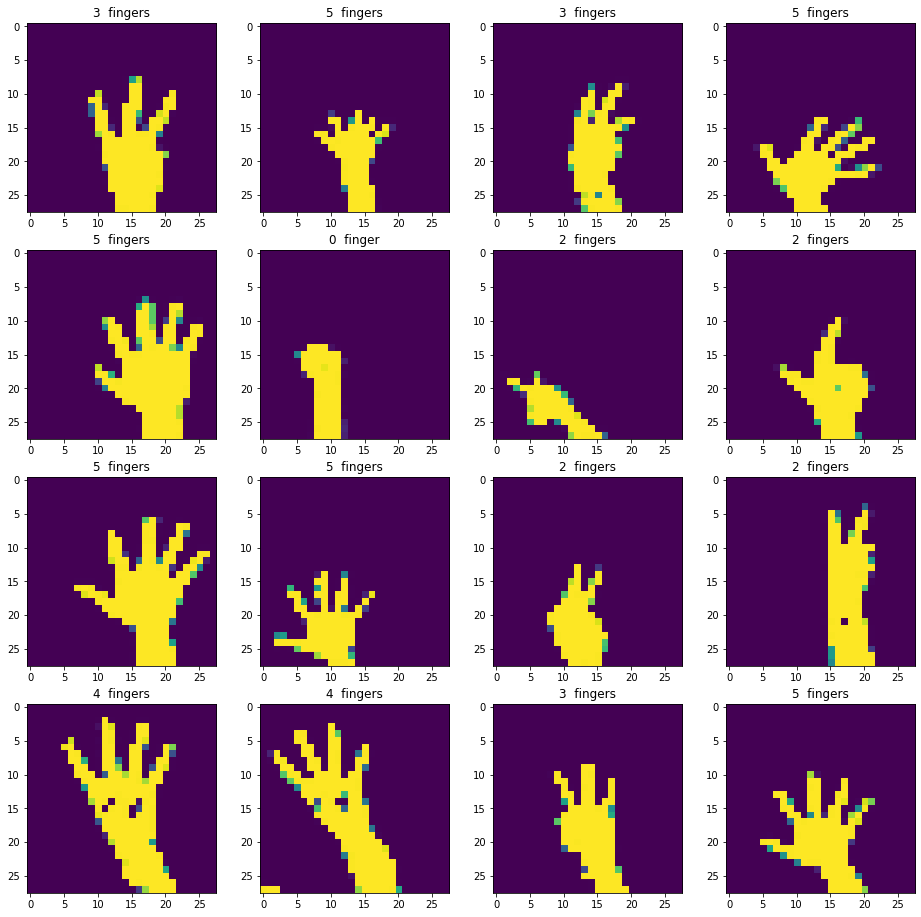

In [7]:
taille = 4
plt.subplots(nrows=taille,
             ncols=taille,
             figsize=(taille*taille,taille*taille))

for i in range(taille):
    for j in range(taille):
        indice = i*taille+j+1
        
        plt.subplot(taille,taille,indice) 
        plt.imshow(x_train[indice])
        plt.title(str(y_train[indice])+"  finger"+(y_train[indice]>=2)*"s")
plt.show()

In [8]:
# We have 6 classes, corresponding to the number between 0 and 5 (included)
num_classes = 6

x_train = np.array(x_train, dtype= np.float32)/255
x_test = np.array(x_test, dtype= np.float32)/255


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(len(x_train), 1, img_rows, img_cols)
    x_test = x_test.reshape(len(x_test), 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("We split the data into : ")
print(len(x_train), "images dedicated to the training")
print(len(x_test), "images dedicated to the test")

We split the data into : 
9084 images dedicated to the training
2272 images dedicated to the test


In [9]:
x_train.shape

(9084, 28, 28, 1)

### Train the model

Following this blog : https://becominghuman.ai/real-time-finger-detection-1e18fea0d1d4

In [10]:
model = Sequential()
model.add(Conv2D(32, (2,2), activation='relu', input_shape=(img_rows, img_cols, 1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [11]:
batch_size = 128

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9084 samples, validate on 2272 samples
Epoch 1/10
9084/9084 [==============================] - 12s 1ms/step - loss: 1.2972 - acc: 0.4745 - val_loss: 0.6378 - val_acc: 0.7742
Epoch 2/10
9084/9084 [==============================] - 11s 1ms/step - loss: 0.6262 - acc: 0.7729 - val_loss: 0.2372 - val_acc: 0.9296
Epoch 3/10
9084/9084 [==============================] - 11s 1ms/step - loss: 0.2610 - acc: 0.9101 - val_loss: 0.1256 - val_acc: 0.9630
Epoch 4/10
9084/9084 [==============================] - 11s 1ms/step - loss: 0.1518 - acc: 0.9491 - val_loss: 0.0564 - val_acc: 0.9837
Epoch 5/10
9084/9084 [==============================] - 11s 1ms/step - loss: 0.0925 - acc: 0.9707 - val_loss: 0.0292 - val_acc: 0.9925
Epoch 6/10
9084/9084 [==============================] - 12s 1ms/step - loss: 0.0721 - acc: 0.9751 - val_loss: 0.0232 - val_acc: 0.9930
Epoch 7/10
9084/9084 [==========================

### Test the model

C:\Users\llesoil\AppData\Local\Continuum\anaconda3\envs\opencv\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  del sys.path[0]


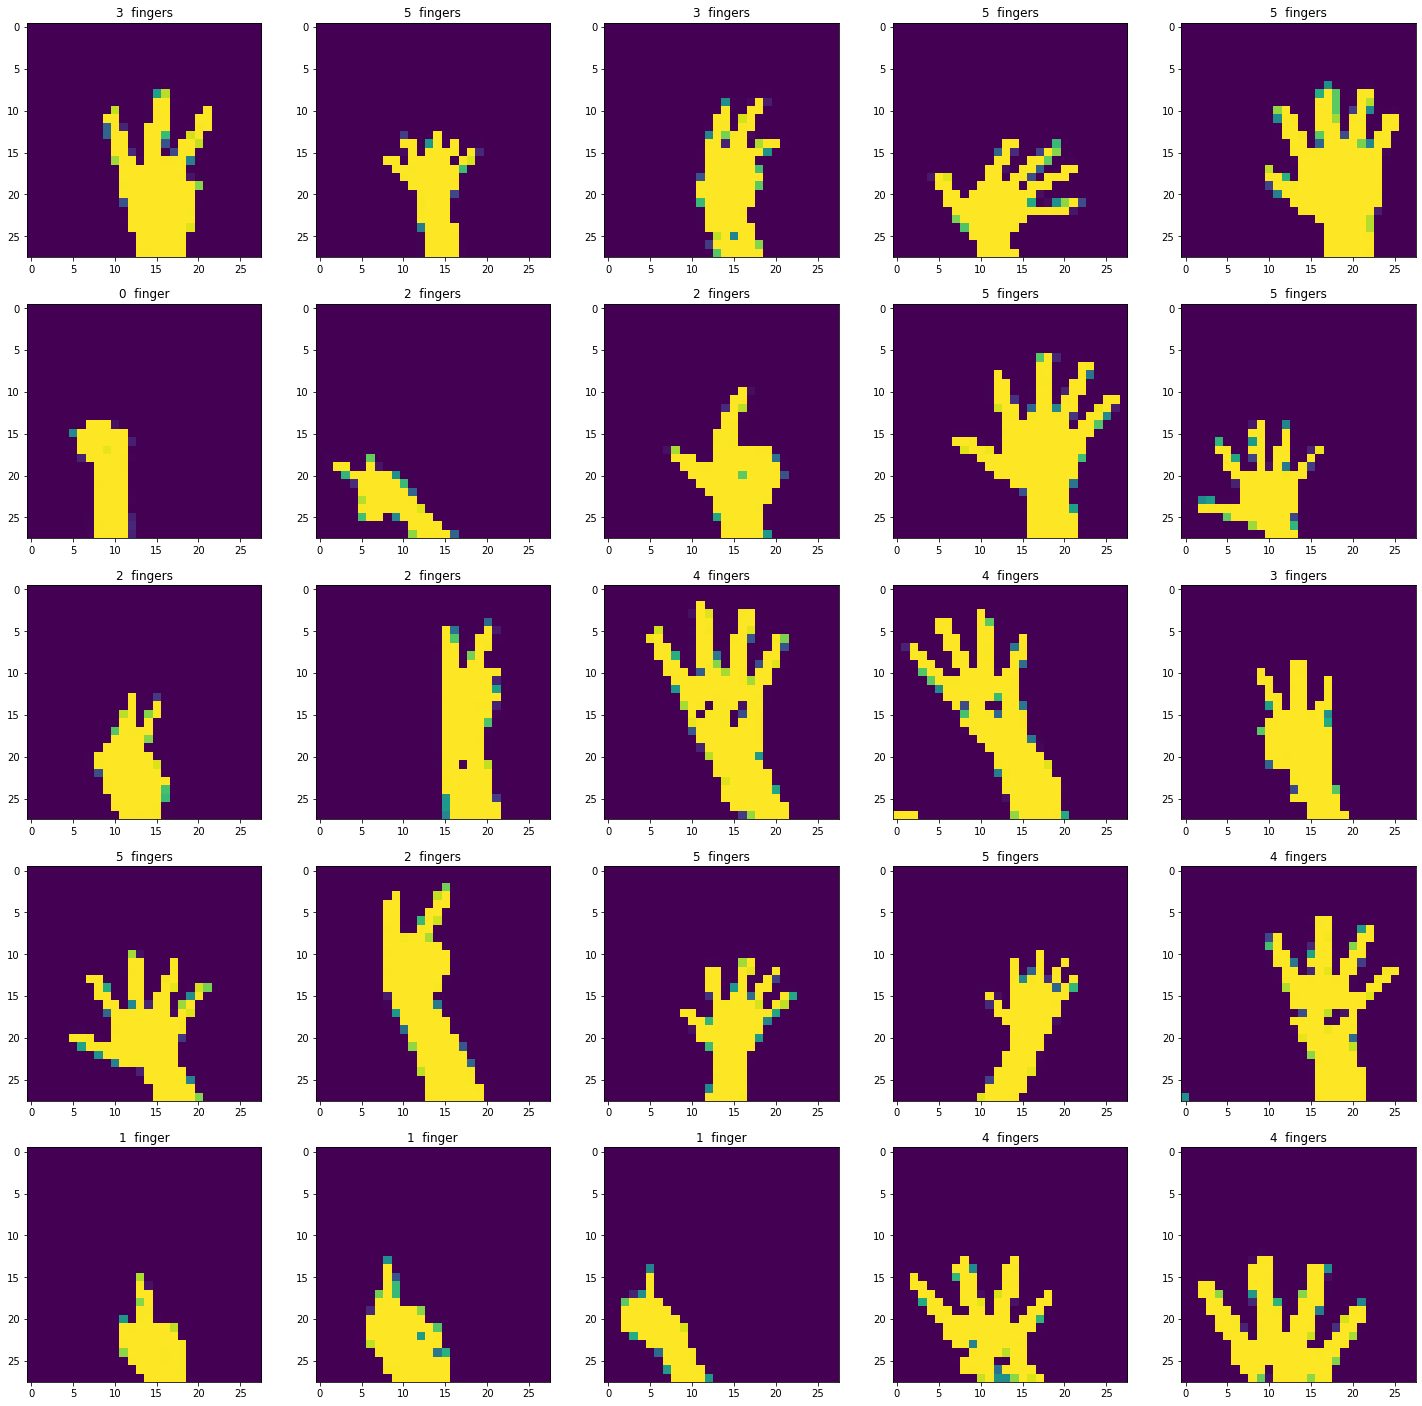

In [12]:
taille = 5
plt.subplots(nrows=taille,
             ncols=taille,
             figsize=(taille*taille,taille*taille))

for i in range(taille): 
    for j in range(taille):
        indice = i*taille+j+1
        img = x_train[indice].reshape(img_rows, img_cols)
        plt.subplot(taille,taille,indice)
        plt.imshow(img)
        count = np.argmax(model.predict(x_train[indice].reshape(1, img_rows, img_cols, 1)))
        plt.title(str(count)+"  finger"+(count>=2)*"s")
plt.show()

In [13]:
model.predict(x_test)

array([[6.0692251e-10, 9.9981505e-01, 1.8494391e-04, 2.8827946e-14,
        3.5942541e-16, 1.1747345e-17],
       [6.2207508e-19, 1.8892736e-23, 7.9094335e-08, 1.9318383e-08,
        9.3752175e-04, 9.9906236e-01],
       [9.6494673e-11, 3.7479069e-05, 9.9994814e-01, 1.4460123e-05,
        7.5265782e-10, 3.0274469e-10],
       ...,
       [2.8888898e-08, 5.6531842e-08, 9.9999952e-01, 3.9951155e-07,
        1.7126229e-08, 9.6437858e-10],
       [9.9999976e-01, 2.6806140e-07, 8.7269220e-10, 2.2190258e-17,
        8.1599418e-19, 7.3363048e-16],
       [2.2624136e-12, 1.1554563e-10, 5.6874673e-05, 9.9977273e-01,
        1.8615649e-06, 1.6850364e-04]], dtype=float32)

In [14]:
x_test.shape

(2272, 28, 28, 1)

## Save the model

In [15]:
model.save("finger_low_resolution.h5")